In [0]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving housing.csv to housing.csv


# New Section

In [0]:
dataset = pd.read_csv('/content/housing.csv')

In [136]:
dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [0]:
del dataset['ocean_proximity']


In [0]:
dataset = dataset.dropna()

(0, 18)

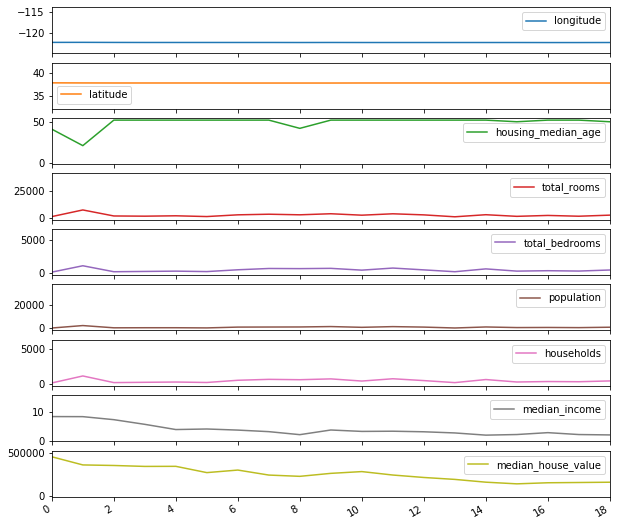

In [139]:
dataset.plot(subplots=True, figsize=(10, 10)); plt.legend(loc='best'); plt.xlim(0, 18)

In [0]:
#for avoiding any anomalous value I am normalizing the dataset 
x = dataset.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()#initializing the MinMax Scaler
x_scaled = min_max_scaler.fit_transform(x)#Normalizing the dataset 
dataset = pd.DataFrame(x_scaled)#converting the datset back to a dataframe


In [141]:
dataset.head()

,0,1,2,3,4,5,6,7,8
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.902266
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.708247
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.695051
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.672783
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.674638


In [0]:
#have taken the 9th column as the target variable which the median house value and from first to 8th column I have taken as features
X = dataset.loc[:, 0:7]
Y = dataset[8]


In [0]:
#Splitted my training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=2003, shuffle = True)

In [0]:
#Converted the testing and training datasets to numpy arrays to work with  PyTorch model 
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
import torch

In [0]:
#for avoiding the Vanishing/exploding gradient issue.
#I am using relu as my activation function
from torch.nn import Linear
from torch.nn import Flatten
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Conv1d
from torch.nn import MaxPool1d


In [0]:
class CnnRegressor(torch.nn.Module):
  #defining the method for initialization
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    #Defining the input layer
    self.input_layer = Conv1d(inputs, batch_size, 1)
    #Defining the max pooling layer
    self.max_pooling_layer= MaxPool1d(1)
    #Adding 2 convolutional layer with 550 as number of hidden neurons
    self.conv_layer = Conv1d(batch_size, 550, 1)
    self.conv1_layer = Conv1d(550, 550, 1)
    #defining the Flatten layer
    self.flatten_layer = Flatten()
    #defining the linear layer
    self.linear_layer = Linear(550,64)
    #defining the ouput layer
    self.outputs_layer = Linear(64, outputs)
  #initializing method to feed the paprameters in to the model
  def feed(self, input):
    #reshaping the input as it expects a 1D or 2D layer so specifying 
    #it as 1 and feeding the parameters to the output layer
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = relu(self.conv1_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.outputs_layer(output)
    return output

In [148]:
from torch.optim import Adamax, SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [149]:
#initializing the batch size
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1],1)
#enabling to use the GPU
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 550, kernel_size=(1,), stride=(1,))
  (conv1_layer): Conv1d(550, 550, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=550, out_features=64, bias=True)
  (outputs_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model,dataset, train = False, optimizer = None):
  #Iterates through the batches and fectches the L1 loss 
  #and R^2 score
  performance = L1Loss()
  score_metric = R2Score()

  avg_loss = 0
  avg_score = 0
  count = 0
  #gets the model prediction for the training dataset 
  #and gets the model L1 Loss and R^2 score
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions,output])
    score = score_metric.compute()

    if(train):
      #clears out any errors and calculates the gradient 
      #and stores the loss before updating the counter
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count += 1 
  return avg_loss / count, avg_score / count

In [151]:
#time library is imported to record the training time
import time
#initializing the number of epochs
epochs = 100
#initializing the optimizer and the learning rate
optimizer = Adamax(model.parameters(), lr = 0.001)
#convert the training datat into torch variables for model using the GPU
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
#Dataloader to process the batches
loader = DataLoader(tensor, batch_size, shuffle= True, drop_last=True)
#initializing a list to store the score
maxR2_score = []
#initializing the start time
start = time.time()
#loop defined for training the data
for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train = True, optimizer=optimizer)
  maxR2_score.append(avg_r2_score)
  print("Epoch" + str(epoch + 1) + ":\n\tLoss" + str(avg_loss)+ "\n\tR^2 Score =" + str(avg_r2_score))
print( "value is " + str(max(maxR2_score)) + " at epoch " + str(maxR2_score.index(max(maxR2_score))+1))
#initializing the stop time
stop = time.time()
print(f"Training time: {stop - start}s")

Epoch1:
	Loss0.11713276400285609
	R^2 Score =0.2643481415565431
Epoch2:
	Loss0.09678047425022313
	R^2 Score =0.6316555831754193
Epoch3:
	Loss0.09253968811210464
	R^2 Score =0.6621724035916879
Epoch4:
	Loss0.08908374698138705
	R^2 Score =0.6825735962375692
Epoch5:
	Loss0.08643656893103731
	R^2 Score =0.7000589359447051
Epoch6:
	Loss0.08572365998053083
	R^2 Score =0.7052761871889263
Epoch7:
	Loss0.08486052671191739
	R^2 Score =0.7083847660562673
Epoch8:
	Loss0.08361161086781352
	R^2 Score =0.7139377136967481
Epoch9:
	Loss0.08309829635362999
	R^2 Score =0.713680200938273
Epoch10:
	Loss0.08285321222216475
	R^2 Score =0.723769371705393
Epoch11:
	Loss0.08119184423018905
	R^2 Score =0.7286950333595855
Epoch12:
	Loss0.0818670016439522
	R^2 Score =0.7224731543739775
Epoch13:
	Loss0.08064915460406565
	R^2 Score =0.7318922829553614
Epoch14:
	Loss0.0806176121620571
	R^2 Score =0.7395934791787148
Epoch15:
	Loss0.08021850962849224
	R^2 Score =0.730405628409881
Epoch16:
	Loss0.07945231682821816
	R^2 

In [152]:
torch.save(model.state_dict, '1110186_1dconv_reg')
models = torch.load('1110186_1dconv_reg')
model.eval()

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 550, kernel_size=(1,), stride=(1,))
  (conv1_layer): Conv1d(550, 550, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=550, out_features=64, bias=True)
  (outputs_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [153]:
#convert the testing datat into torch variables for model using the GPU
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
#Dataloader to process the batches
loader = DataLoader (tensor, batch_size, shuffle= True, drop_last=True)
#initializing the start time
start = time.time()
#print the average performance
avg_loss, avg_r2_score = model_loss(model, loader)
#initializing the stop time
stop = time.time()
print("the model's L1 loss is " + str(avg_loss))  
print("the R^2 score is " +  str(avg_r2_score))
print(f"Testing time: {stop - start}s")

the model's L1 loss is 0.06832530290361434
the R^2 score is 0.8036522527341633
Testing time: 0.11425662040710449s


In [154]:
def number_of_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
x = number_of_trainable_parameters(model)
print("number of number_of_trainable_parameters " + str(x))

number of number_of_trainable_parameters 374705
